## Policy gradient

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
from childNet import ChildNet

combinations = [['EOS'], [1, 'EOS'], [4, 'EOS'], [1, 1, 'EOS'], [1, 4, 'EOS'], [4, 1, 'EOS'], [4, 4, 'EOS']]
layer_limit = 2 # max_layers

cn = ChildNet(layer_limit)
nb_epochs = 1000

In [2]:
from childNet_baseline import ChildNet

combinations = [['EOS'], [1, 'EOS'], [4, 'EOS'], [1, 1, 'EOS'], [1, 4, 'EOS'], [4, 1, 'EOS'], [4, 4, 'EOS']]
layer_limit = 2 # max_layers

cn = ChildNet(layer_limit)
nb_epochs = 1000

for combination in combinations:
    val_acc = []
    for i in range(20):
        val_acc += [cn.compute_reward(combination, nb_epochs)] #[8, 16, 2, 8, 32, 'EOS']
        
    print(combination, np.mean(val_acc))


['EOS'] 0.815857145190239
[1, 'EOS'] 0.7605714306235314
[4, 'EOS'] 0.8545714288949966
[1, 1, 'EOS'] 0.6364285841584205
[1, 4, 'EOS'] 0.7950000032782555
[4, 1, 'EOS'] 0.7324285760521889
[4, 4, 'EOS'] 0.8479999989271164


[LSTMCell](https://discuss.pytorch.org/t/lstmcell-example-with-lstm/25925)

In [3]:
n_hidden = 24
possible_hidden_units = [1, 4, 'EOS'] #[2, 4, 8, 16, 32, 'EOS']
n_outputs = len(possible_hidden_units)

batch_size = 1
learning_rate = 0.001 

class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_hidden, n_outputs, learning_rate, layer_limit):
        super(PolicyNet, self).__init__()
        
        self.layer_limit = layer_limit
        
        self.lstm = nn.LSTMCell(n_outputs, n_hidden)
        #self.lstm2 = nn.LSTMCell(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)

        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, training):
        outputs = []
        actions = []
        action = not None #initialize action to don't break the while condition 
        counter_nb_layers = 0
        
        h_t = torch.zeros(batch_size, n_hidden, dtype=torch.float)
        c_t = torch.zeros(batch_size, n_hidden, dtype=torch.float)
        output = torch.zeros(batch_size, n_outputs, dtype=torch.float)
        
        #h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        #c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        
        while counter_nb_layers<self.layer_limit and action!=n_outputs-1: #action is not EOS
            h_t, c_t = self.lstm(output, (h_t, c_t))
            #h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = F.softmax(self.out(h_t), dim=1)
            
            if training:
                action = (np.cumsum(output.detach().numpy()) > np.random.rand()).argmax() # sample action
            else: #eval
                action = (output.detach().numpy()).argmax()
            
            outputs += [output]
            actions += [action]
            counter_nb_layers += 1
        
        outputs = torch.stack(outputs, 1).squeeze(2)
        outputs.view(-1, n_outputs)
        
        return outputs, actions
    
    def loss(self, action_probabilities, returns, baseline):
        #return -torch.mean(torch.mul(torch.log(action_probabilities), returns))
        return torch.mul((returns-baseline),torch.mean(torch.log(action_probabilities)))
'''
    def loss(self):        
        # moving average baseline
        if baseline is None:
            baseline = rewards
        else:
            decay = self.args.ema_baseline_decay
            baseline = decay * baseline + (1 - decay) * rewards = rewards + decay * (baseline - rewards)
            
        adv = rewards - baseline
        loss = -log_probs*adv

        loss = loss.sum()  # or loss.mean()
'''

'\n    def loss(self):        \n        # moving average baseline\n        if baseline is None:\n            baseline = rewards\n        else:\n            decay = self.args.ema_baseline_decay\n            baseline = decay * baseline + (1 - decay) * rewards = rewards + decay * (baseline - rewards)\n            \n        adv = rewards - baseline\n        loss = -log_probs*adv\n\n        loss = loss.sum()  # or loss.mean()\n'

In [4]:
def indexes_to_actions(actions):
    if actions[-1]==n_outputs-1:
        return [possible_hidden_units[action] for action in actions]
    else:
        return [possible_hidden_units[action] for action in actions] + ['EOS']

In [5]:
#Test Forward pass

policy = PolicyNet(n_hidden, n_outputs, learning_rate, layer_limit)
outputs, actions = policy(True)
outputs, actions, indexes_to_actions(actions)

(tensor([[[0.3682, 0.2885, 0.3433]]], grad_fn=<SqueezeBackward1>),
 [2],
 ['EOS'])

In [6]:
# training settings

num_episodes = 50
val_freq = 1 # validation frequency
decay = 0.9
# setup policy network

policy = PolicyNet(n_hidden, n_outputs, learning_rate, layer_limit)
baseline = torch.zeros(15, dtype=torch.float)

# train policy network

try:
    training_rewards, val_rewards, losses = [], [], []
    baseline = torch.zeros(15, dtype=torch.float)
    print('start training')
    for i in range(num_episodes):
        rollout = []
        training = True
        with torch.no_grad():
            full_a_probs, actions = policy(training)
        # policy gradient update
        policy.optimizer.zero_grad()
        max_r = 0
        for j in range(5):
            r = cn.compute_reward(indexes_to_actions(actions), nb_epochs)#*100
            
            if r>max_r:
                max_r = r
        max_r = max_r**3
        a_probs = torch.tensor([float(full_a_probs[0, i,action].detach().numpy()) for i,action in enumerate(actions)])
        loss = policy.loss(a_probs, Variable(torch.tensor(max_r),requires_grad=True), torch.mean(baseline))
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(max_r)
        losses.append(loss.item())
        # actualize baseline
        baseline = torch.cat((baseline[1:]*decay, torch.tensor([max_r*(1-decay)], dtype=torch.float)))
        # print
        if (i+1) % val_freq == 0:
            val_acc = cn.compute_reward(indexes_to_actions(policy(not training)[1]), nb_epochs)
            val_rewards.append(val_acc)
            print('{:4d}. mean training reward: {:6.2f}, mean loss: {:7.4f}, mean val reward: {:6.3f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(losses[-val_freq:]), val_acc))
            
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
   1. mean training reward:   0.67, mean loss: -0.7059, mean val reward:  0.854
   2. mean training reward:   0.60, mean loss: -0.6739, mean val reward:  0.863
   3. mean training reward:   0.62, mean loss: -0.6561, mean val reward:  0.889
   4. mean training reward:   0.79, mean loss: -0.8035, mean val reward:  0.877
   5. mean training reward:   0.76, mean loss: -0.7621, mean val reward:  0.860
   6. mean training reward:   0.66, mean loss: -0.6605, mean val reward:  0.949
   7. mean training reward:   0.66, mean loss: -0.6763, mean val reward:  0.874
   8. mean training reward:   0.63, mean loss: -0.7265, mean val reward:  0.851
   9. mean training reward:   0.58, mean loss: -0.5978, mean val reward:  0.854
  10. mean training reward:   0.59, mean loss: -0.6028, mean val reward:  0.843
  11. mean training reward:   0.66, mean loss: -0.6931, mean val reward:  0.880
  12. mean training reward:   0.62, mean loss: -0.6327, mean val reward:  0.929
  13. mean training rewar

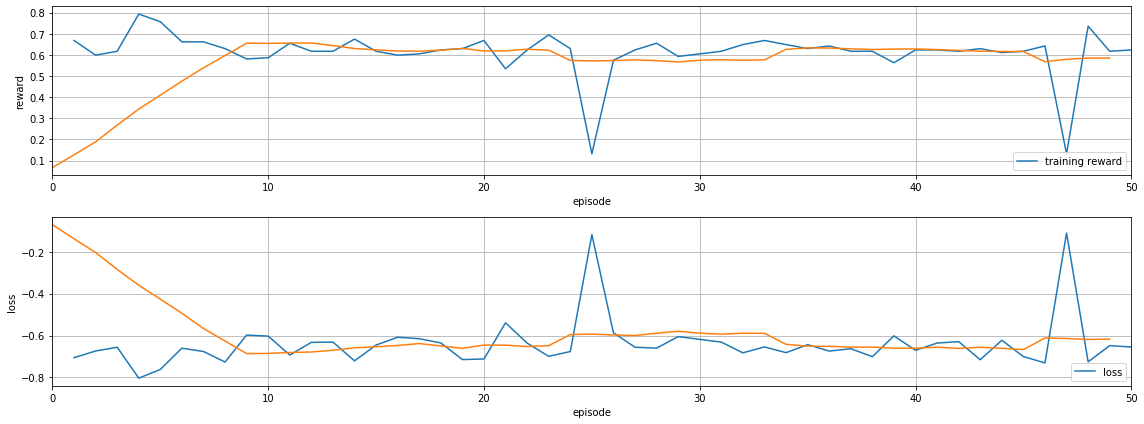

In [8]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))#, plt.ylim((-20,20))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Text(0, 0.5, 'val reward')

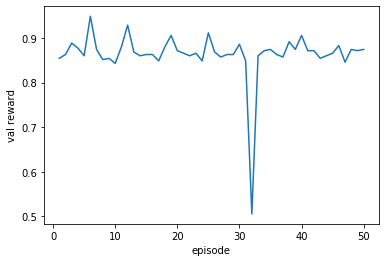

In [9]:
plt.plot(range(1, len(val_rewards)+1), val_rewards)
plt.xlabel('episode'); plt.ylabel('val reward')

In [10]:
indexes_to_actions(policy(not training)[1])

[4, 4, 'EOS']